## Imports

In [1]:
# Base Imports
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import warnings
warnings.filterwarnings('ignore')

#Data Processing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

#Accuracy and Train/Test Split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#SVM Imports
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Decision tree and Random Forest imports
from sklearn.tree import DecisionTreeClassifier

#Random Forest
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
#NN
from sklearn.neural_network import MLPClassifier
import shap
# Voting Classifier
from sklearn.ensemble import VotingClassifier

## Data Provessing

In [2]:
Function = pd.read_csv("C:/Users/ritwi/OneDrive/Documents/MS_DataScience/Thesis/Project/Data/Sample/sample_function.csv")
Function = Function.drop('go_function', axis=1)

In [3]:
Names = pd.read_csv("C:/Users/ritwi/OneDrive/Documents/MS_DataScience/Thesis/Project/Data/Sample/sample_function.csv")
Names = Names.drop('t_tax_seq_id', axis=1)
Names = Names.drop_duplicates()

In [4]:
Sequence = pd.read_csv("C:/Users/ritwi/OneDrive/Documents/MS_DataScience/Thesis/Project/Data/Sample/sample.csv")
Sequence = Sequence.drop('tax_id', axis=1)

def calculate_amino_acid_counts(sequence):
    return ProteinAnalysis(sequence).count_amino_acids()

In [5]:
Sequence['amino_acid_counts'] = Sequence['seq'].apply(calculate_amino_acid_counts)
amino_acid_counts_df = pd.DataFrame(Sequence['amino_acid_counts'].tolist())
Seq_df = pd.concat([Sequence[['tax_seq_id']], amino_acid_counts_df], axis=1)

In [6]:
one_hot_encoded = pd.get_dummies(Function, columns=['go_go_id'])
one_hot_encoded = one_hot_encoded.groupby('t_tax_seq_id').sum().reset_index()
one_hot_encoded.columns = one_hot_encoded.columns.str.replace('go_go_id_', '')

In [7]:
Merge_df = pd.merge(Seq_df, one_hot_encoded, left_on='tax_seq_id', right_on='t_tax_seq_id', how='inner')
Merge_df = Merge_df.drop(columns=['t_tax_seq_id'])
Merge_df.set_index('tax_seq_id', inplace=True)

In [8]:
Main = Merge_df
go_term_columns = Main.columns[20:]
seq_info = Main.columns[:20]

## Base Data

In [9]:
X = Main.drop(columns=go_term_columns)
y = Main.drop(columns=seq_info)

In [10]:
columns_to_keep = [col for col in y.columns if y[col].sum() > 700]
y = y[columns_to_keep]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Full Data

In [12]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer=TfidfTransformer(smooth_idf=False,use_idf=True)
tfidf_transformer.fit(X)
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=X.columns,columns=["idf_weights"])
df_idf = df_idf.T
X_freq = X.div(X.sum(axis=1), axis=0)
tfidf_X = X_freq * df_idf.iloc[0]

In [13]:
def count_C(sequence):
    return sequence.count('C')
def count_H(sequence):
    return sequence.count('H')
def count_E(sequence):
    return sequence.count('E')

In [14]:
Sec_Seq = pd.read_csv("C:/Users/ritwi/OneDrive/Documents/MS_DataScience/Thesis/Project/Data/Sample/secondary_struct.csv")
Sec_Seq = Sec_Seq.set_index('sec_seq_id')
Sec_Seq['S_C'] = Sec_Seq['sec_seq'].apply(count_C)
Sec_Seq['S_H'] = Sec_Seq['sec_seq'].apply(count_H)
Sec_Seq['S_E'] = Sec_Seq['sec_seq'].apply(count_E)
Sec_Seq = Sec_Seq.drop(columns=['sec_seq'])
Sec_Seq = Sec_Seq.div(Sec_Seq.sum(axis=1), axis=0)

tfidf_transformer = TfidfTransformer()
tfidf_transformer=TfidfTransformer(smooth_idf=False,use_idf=True)
tfidf_transformer.fit(Sec_Seq)
Sec_Seq_idf = pd.DataFrame(tfidf_transformer.idf_, index=Sec_Seq.columns,columns=["idf_weights"])
Sec_Seq_idf = Sec_Seq_idf.T
Sec_Seq_freq = Sec_Seq.div(Sec_Seq.sum(axis=1), axis=0)
tfidf_Sec_Seq = Sec_Seq_freq * Sec_Seq_idf.iloc[0]

In [15]:
def calculate_hydrophobicity(sequence):
    hydrophobicity = 0
    for amino_acid in sequence:
        amino_acid = amino_acid.upper()
        if amino_acid in hydrophobicity_scale:
            hydrophobicity += hydrophobicity_scale[amino_acid]
        else:
            # You can handle unknown amino acids or non-standard residues here
            #print(f"Unknown amino acid: {amino_acid}")
            pass
    return hydrophobicity

In [16]:
hydrophobicity_scale = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
                        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
                        'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
                        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}
hydropob_X = Sequence.copy()
hydropob_X = hydropob_X.set_index('tax_seq_id')
hydropob_X = hydropob_X.drop(columns=['amino_acid_counts'])
hydropob_X["Hydrophobicity"] = hydropob_X['seq'].apply(calculate_hydrophobicity)
hydropob_X = hydropob_X.drop(columns=['seq'])

In [17]:
def calculate_pka(sequence):
    pka = 0
    for amino_acid in sequence:
        amino_acid = amino_acid.upper()
        if amino_acid in pka_scale:
            pka += pka_scale[amino_acid]
        else:
            # You can handle unknown amino acids or non-standard residues here
            #print(f"Unknown amino acid: {amino_acid}")
            pass
    return pka

In [18]:
pka_scale = {'A':2.34, 'R':2.17, 'N':2.02, 'D':1.88, 'C':1.96,
             'Q':2.17, 'E':2.19, 'G':2.34, 'H':1.82, 'I':2.36,
             'L':2.36, 'K':2.18, 'M':2.28, 'F':1.83, 'P':1.99,
             'S':2.21, 'T':2.09, 'W':2.83, 'Y':2.20, 'V':2.32}

In [19]:
pka_X = Sequence.copy()
pka_X = pka_X.set_index('tax_seq_id')
pka_X = pka_X.drop(columns=['amino_acid_counts'])
pka_X["PKA"] = pka_X['seq'].apply(calculate_pka)
pka_X = pka_X.drop(columns=['seq'])

In [20]:
M_1_X = pd.merge(pka_X, hydropob_X,  left_index=True, right_index=True)
M_2_X = pd.merge(M_1_X,tfidf_Sec_Seq, left_index=True,right_index=True)
M_3_X = pd.merge(M_2_X,tfidf_X, left_index=True,right_index=True)

In [21]:
Ter_Seq = pd.read_csv("C:/Users/ritwi/OneDrive/Documents/MS_DataScience/Thesis/Project/Data/Sample/tertiary_struct.csv")
Ter_Seq = Ter_Seq.drop(columns=['Short name'])
Ter_Seq = Ter_Seq.drop_duplicates()

In [22]:
one_hot_encoded_1 = pd.get_dummies(Ter_Seq, columns=['Accession'])
one_hot_encoded_1 = one_hot_encoded_1.groupby('Query').sum()
one_hot_encoded_1.columns = one_hot_encoded_1.columns.str.replace('Accession_', '')

In [23]:
M_X = pd.merge(M_3_X, one_hot_encoded_1, left_index=True,right_index=True, how='left')
M_X = M_X.fillna(0)

In [24]:
X_t, X_tes, y_t, y_tes = train_test_split(M_X, y, test_size=0.3, random_state=42)

## Full Data + Expermental Data

In [25]:
def count_A(sequence):
    return sequence.count('A')
def count_R(sequence):
    return sequence.count('R')
def count_P(sequence):
    return sequence.count('P')
def count_C(sequence):
    return sequence.count('C')
def count_B(sequence):
    return sequence.count('B')
def count_U(sequence):
    return sequence.count('U')
def count_S(sequence):
    return sequence.count('S')

In [26]:
Amino_pro = pd.read_csv("C:/Users/ritwi/OneDrive/Documents/MS_DataScience/Thesis/Project/Data/Sample/Amino_prop.csv")
Amino_pro['P_A'] = Amino_pro['amino_prop'].apply(count_A)
Amino_pro['P_R'] = Amino_pro['amino_prop'].apply(count_R)
Amino_pro['P_P'] = Amino_pro['amino_prop'].apply(count_P)
Amino_pro['P_C'] = Amino_pro['amino_prop'].apply(count_C)
Amino_pro['P_B'] = Amino_pro['amino_prop'].apply(count_B)
Amino_pro['P_U'] = Amino_pro['amino_prop'].apply(count_U)
Amino_pro['P_S'] = Amino_pro['amino_prop'].apply(count_S)
Amino_pro = Amino_pro.set_index('id')
Amino_pro = Amino_pro.drop(columns=['amino_prop'])

tfidf_transformer = TfidfTransformer()
tfidf_transformer = TfidfTransformer(smooth_idf=False,use_idf=True)
tfidf_transformer.fit(Amino_pro)
Amino_pro_idf = pd.DataFrame(tfidf_transformer.idf_, index=Amino_pro.columns,columns=["idf_weights"])
Amino_pro_idf = Amino_pro_idf.T
Amino_pro_freq = Amino_pro.div(Amino_pro.sum(axis=1), axis=0)
tfidf_Amino_pro = Amino_pro_freq * Amino_pro_idf.iloc[0]

In [27]:
M_X_M = pd.merge(M_X, tfidf_Amino_pro, left_index=True,right_index=True, how='inner')

In [28]:
X_tm, X_tesm, y_tm, y_tesm = train_test_split(M_X_M, y, test_size=0.3, random_state=42)

##  Removed Secondary Structure, Hydrophpbicity, and PKA

In [29]:
M_X_M_R = M_X_M.drop(columns=['Hydrophobicity','PKA','S_C','S_H','S_E'])
X_tmr, X_tesmr, y_tmr, y_tesmr = train_test_split(M_X_M_R, y, test_size=0.3, random_state=42)

In [30]:
X_train, X_test, y_train, y_test

(             A   C   D   E   F   G   H   I   K   L   M   N   P   Q   R   S  \
 tax_seq_id                                                                   
 O67056       8   4  13  15   9  13   4  14  22  26   3  15   6   5  16  18   
 A0A6G9KHD3   2   0   2   2   1   2   0   5   3   4   3   0   2   0   0   1   
 P12579      13   0  22  29   8   8   2  16  19  18   7  22  12   2  11  23   
 O60020      47   4  18   4  13  45   5  20  15  25   2  10  16  17   5  59   
 B3FTL2      77  12  53  74  38  65  40  44  59  97  24  25  76  36  38  61   
 ...         ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
 A0A2L0V156  22   2  12  12   5  12   7   6   5  18  10  12   7   8  10   7   
 G3KIM6      31   9  28  23  13  33   9  32  26  27  13  11  12   9  14  18   
 Q44057      17   1   6  13   6   5   6   7   8  16   5   4   3   7   6  14   
 Q2VL32      40   2  37  28  34  33  18  29  25  39   5  37  20  16  19  51   
 P06427       7  10   5  12   6   5   5   9  10  15 

In [31]:
X_t, X_tes, y_t, y_tes

(                PKA  Hydrophobicity       S_C       S_H       S_E         A  \
 O67056       512.92          -108.9  0.502128  0.380282  0.185830  0.034846   
 A0A6G9KHD3    82.19            36.8  0.324324  0.736373  0.000000  0.055329   
 P12579       519.93          -222.2  0.626556  0.406991  0.000000  0.055214   
 O60020       897.31            55.1  0.590123  0.083419  0.415905  0.118787   
 B3FTL2      2157.36          -288.9  0.493428  0.394499  0.180408  0.079693   
 ...             ...             ...       ...       ...       ...       ...   
 A0A2L0V156   427.13           -67.9  0.329897  0.730300  0.000000  0.116077   
 G3KIM6       804.28            -0.8  0.455041  0.436527  0.180188  0.086461   
 Q44057       319.91           -27.8  0.282759  0.398352  0.438852  0.120007   
 Q2VL32      1113.57          -233.6  0.567251  0.329286  0.162957  0.079812   
 P06427       323.06           -79.4  0.510067  0.446173  0.100487  0.048088   
 
                    C         D       

In [32]:
X_tm, X_tesm, y_tm, y_tesm

(                PKA  Hydrophobicity       S_C       S_H       S_E         A  \
 O67056       512.92          -108.9  0.502128  0.380282  0.185830  0.034846   
 A0A6G9KHD3    82.19            36.8  0.324324  0.736373  0.000000  0.055329   
 P12579       519.93          -222.2  0.626556  0.406991  0.000000  0.055214   
 O60020       897.31            55.1  0.590123  0.083419  0.415905  0.118787   
 B3FTL2      2157.36          -288.9  0.493428  0.394499  0.180408  0.079693   
 ...             ...             ...       ...       ...       ...       ...   
 A0A2L0V156   427.13           -67.9  0.329897  0.730300  0.000000  0.116077   
 G3KIM6       804.28            -0.8  0.455041  0.436527  0.180188  0.086461   
 Q44057       319.91           -27.8  0.282759  0.398352  0.438852  0.120007   
 Q2VL32      1113.57          -233.6  0.567251  0.329286  0.162957  0.079812   
 P06427       323.06           -79.4  0.510067  0.446173  0.100487  0.048088   
 
                    C         D       

In [33]:
X_tmr, X_tesmr, y_tmr, y_tesmr

(                   A         C         D         E         F         G  \
 O67056      0.034846  0.019822  0.057408  0.066835  0.039986  0.056354   
 A0A6G9KHD3  0.055329  0.000000  0.056095  0.056599  0.028218  0.055065   
 P12579      0.055214  0.000000  0.094733  0.125998  0.034658  0.033816   
 O60020      0.118787  0.011502  0.046122  0.010342  0.033513  0.113189   
 B3FTL2      0.079693  0.014130  0.055613  0.078346  0.040116  0.066952   
 ...              ...       ...       ...       ...       ...       ...   
 A0A2L0V156  0.116077  0.012005  0.064191  0.064768  0.026909  0.063012   
 G3KIM6      0.086461  0.028558  0.079175  0.065621  0.036984  0.091600   
 Q44057      0.120007  0.008031  0.042941  0.093876  0.043203  0.035128   
 Q2VL32      0.079812  0.004540  0.074848  0.057151  0.069198  0.065530   
 P06427      0.048088  0.078156  0.034824  0.084329  0.042043  0.034185   
 
                    H         I         K         L  ...  smart01008  \
 O67056      0.018640  0.0

## Poly SVM

https://blog.devgenius.io/machine-learning-algorithm-series-polynomial-kernel-svm-understanding-the-basics-and-applications-89b4b42df137

In [ ]:
def S_V_M(X_1,X_2,y_1,y_2,poly_kernel_svm_clf):
    #GO:0005488
    Records = pd.DataFrame(columns=['Go-Ids', 'F1-Score','Accuracy','Confusion_Matrix']) 
    for column in y_1.columns:
        temp = []
        a = y_1[column]
        b = y_2[column]
        poly_kernel_svm_clf.fit(X_1, a)
        y_pred = poly_kernel_svm_clf.predict(X_2)
        confusion = confusion_matrix(b, y_pred)
        temp.append(column)
        temp.append(f1_score(b, y_pred, average='binary'))
        temp.append(accuracy_score(b,y_pred))
        temp.append(confusion)
        Records.loc[len(Records)] = temp
    mean_confusion_matrix = sum(Records['Confusion_Matrix']) / len(Records)
    Records = Records.drop(columns=['Confusion_Matrix'])
    Records = Records.merge(Names, left_on='Go-Ids', right_on='go_go_id')
    Records = Records.drop(columns=['go_go_id'])
    Records = Records.iloc[:,[0,3,1,2]]
    Records = Records.sort_values(by='Accuracy', ascending=True)

    return Records, mean_confusion_matrix

In [ ]:
poly_kernel_svm_clf_1 = Pipeline([("scaler", StandardScaler()),
                                ("svm_clf", SVC(kernel="poly",degree=3, coef0=1, C=5))])
Base, conf_svm_1 = S_V_M(X_train, X_test, y_train, y_test,poly_kernel_svm_clf_1)
Base

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_svm_1)
disp.plot(values_format='.0f')
plt.show()

In [ ]:
poly_kernel_svm_clf_2 = Pipeline([("scaler", StandardScaler()),
                                  ("svm_clf", SVC(kernel="poly",degree=3, coef0=1, C=5))])
Full, conf_svm_2 = S_V_M(X_t, X_tes, y_t, y_tes,poly_kernel_svm_clf_2)
Full

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_svm_2)
disp.plot(values_format='.0f')
plt.show()

In [ ]:
poly_kernel_svm_clf_3 = Pipeline([("scaler", StandardScaler()),
                                  ("svm_clf", SVC(kernel="poly",degree=3, coef0=1, C=5))])
Full_Exp, conf_svm_3 = S_V_M(X_tm, X_tesm, y_tm, y_tesm,poly_kernel_svm_clf_3)
Full_Exp

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_svm_3)
disp.plot(values_format='.0f')
plt.show()

In [ ]:
poly_kernel_svm_clf_4 = Pipeline([("scaler", StandardScaler()),
                                  ("svm_clf", SVC(kernel="poly",degree=3, coef0=1, C=5))])
Removed, conf_svm_4 = S_V_M(X_tmr, X_tesmr, y_tmr, y_tesmr,poly_kernel_svm_clf_4)
Removed

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_svm_4)
disp.plot(values_format='.0f')
plt.show()

## Decision Tree

In [ ]:
def Decision_Tree(X_D_1,X_D_2,y_D_1,y_D_2, tree_clf):
    DT_Records = pd.DataFrame(columns=['Go-Ids', 'F1-Score','Accuracy', 'Confusion_Matrix']) 
    for column in y_D_1.columns:
        temp = []
        a = y_D_1[column]
        b = y_D_2[column]
        tree_clf.fit(X_D_1, a)
        y_pred_Dt = tree_clf.predict(X_D_2)
        confusion = confusion_matrix(b, y_pred_Dt)
        temp.append(column)
        temp.append(f1_score(b, y_pred_Dt, average='binary'))
        temp.append(accuracy_score(b,y_pred_Dt))
        temp.append(confusion)
        DT_Records.loc[len(DT_Records)] = temp
    mean_confusion_matrix_dt = sum(DT_Records['Confusion_Matrix']) / len(DT_Records)
    DT_Records = DT_Records.drop(columns=['Confusion_Matrix'])
    DT_Records =  DT_Records.merge(Names, left_on='Go-Ids', right_on='go_go_id')
    DT_Records =  DT_Records.drop(columns=['go_go_id'])
    DT_Records =  DT_Records.iloc[:,[0,3,1,2]]
    DT_Records =  DT_Records.sort_values(by='Accuracy', ascending=True)
    return DT_Records,  mean_confusion_matrix_dt

In [ ]:
tree_clf_1 = DecisionTreeClassifier(random_state=42)
Base_dt, conf_dt_1 = Decision_Tree(X_train, X_test, y_train, y_test,tree_clf_1)
Base_dt

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_dt_1)
disp.plot(values_format='.0f')
plt.show()

In [ ]:
tree_clf_2 = DecisionTreeClassifier(random_state=42)
Full_dt, conf_dt_2 = Decision_Tree(X_t, X_tes, y_t, y_tes,tree_clf_2)
Full_dt

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_dt_2)
disp.plot(values_format='.0f')
plt.show()

In [ ]:
tree_clf_3 = DecisionTreeClassifier(random_state=42)
Full_Exp_dt, conf_dt_3 = Decision_Tree(X_tm, X_tesm, y_tm, y_tesm, tree_clf_3)
Full_Exp_dt

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_dt_3)
disp.plot(values_format='.0f')
plt.show()

In [ ]:
tree_clf_4 = DecisionTreeClassifier(random_state=42)
Removed_dt, conf_dt_4 = Decision_Tree(X_tmr, X_tesmr, y_tmr, y_tesmr,tree_clf_4)
Removed_dt

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_dt_4)
disp.plot(values_format='.0f')
plt.show()

## Random Forest

In [34]:
def Random_Forest(X_R_1,X_R_2,y_R_1,y_R_2,rnd_clf):
    Records_RF = pd.DataFrame(columns=['Go-Ids', 'F1-Score','Accuracy', 'Confusion_Matrix'])
    all_forest_importances = pd.DataFrame(index = X_R_1.columns.values.tolist())
    for column in y_R_1.columns:
        temp = []
        a = y_R_1[column]
        b = y_R_2[column]
        rnd_clf.fit(X_R_1, a)
        y_pred_r = rnd_clf.predict(X_R_2)
        confusion = confusion_matrix(b, y_pred_r)
        temp.append(column)
        temp.append(f1_score(b, y_pred_r, average='binary'))
        temp.append(accuracy_score(b,y_pred_r))
        temp.append(confusion)
        Records_RF.loc[len(Records_RF)] = temp

        importances = rnd_clf.feature_importances_
        forest_importances = pd.Series(importances,index = X_R_1.columns.values.tolist())
        all_forest_importances[column] = forest_importances
        
    mean_confusion_matrix_r = sum(Records_RF['Confusion_Matrix']) / len(Records_RF)
    Records_RF = Records_RF.drop(columns=['Confusion_Matrix'])
    row_avg = all_forest_importances.mean(axis=1)
    all_forest_importances['mean'] = row_avg
    all_forest_importances = all_forest_importances[['mean']]
    all_forest_importances = all_forest_importances.sort_values(by='mean', ascending=False)
    top_10 = all_forest_importances.head(20)
    top_10 = top_10.sort_values(by='mean', ascending=True)

    Records_RF = Records_RF.merge(Names, left_on='Go-Ids', right_on='go_go_id')
    Records_RF = Records_RF.drop(columns=['go_go_id'])
    Records_RF =  Records_RF.iloc[:,[0,3,1,2]]
    Records_RF =  Records_RF.sort_values(by='Accuracy', ascending=True)
    return Records_RF, mean_confusion_matrix_r, top_10

In [35]:
rnd_clf_1 = RandomForestClassifier(n_estimators=100, random_state=42)
Base_rf, conf_r_1, top_10 = Random_Forest(X_train, X_test, y_train, y_test, rnd_clf_1)
Base_rf

,Go-Ids,go_function,F1-Score,Accuracy
5,GO:0008150,biological_process,0.619962,0.578723
2,GO:0005488,binding,0.430556,0.651064
4,GO:0005575,cellular_component,0.348485,0.725532
0,GO:0003674,molecular_function,0.843893,0.745745
7,GO:0009987,cellular process,0.293578,0.754255
3,GO:0005515,protein binding,0.280255,0.759574
1,GO:0003824,catalytic activity,0.676471,0.765957
6,GO:0008152,metabolic process,0.377143,0.768085
9,GO:0110165,cellular anatomical entity,0.367347,0.769149
8,GO:0071704,organic substance metabolic process,0.355072,0.810638


In [36]:
top_10

,mean
M,0.040968
W,0.040968
C,0.044866
N,0.045818
Q,0.047256
F,0.048470
P,0.048608
K,0.048696
R,0.049621
E,0.050215


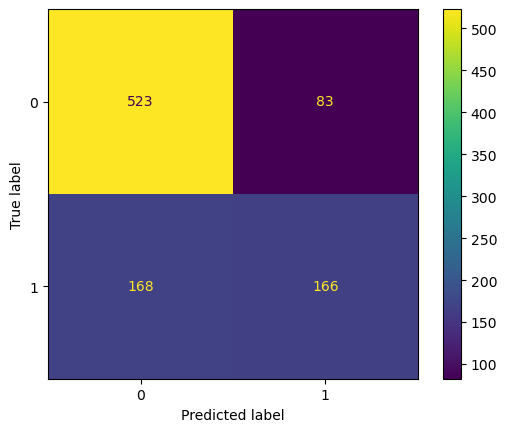

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_r_1)
disp.plot(values_format='.0f')
plt.show()

In [38]:
rnd_clf_2 = RandomForestClassifier(n_estimators=100, random_state=42)
Full_rf, conf_r_2, top_10_f = Random_Forest(X_t, X_tes, y_t, y_tes,rnd_clf_2)
Full_rf

,Go-Ids,go_function,F1-Score,Accuracy
5,GO:0008150,biological_process,0.637655,0.565957
2,GO:0005488,binding,0.353167,0.641489
4,GO:0005575,cellular_component,0.379747,0.739362
3,GO:0005515,protein binding,0.226667,0.753191
0,GO:0003674,molecular_function,0.850065,0.755319
7,GO:0009987,cellular process,0.230508,0.758511
1,GO:0003824,catalytic activity,0.689441,0.787234
9,GO:0110165,cellular anatomical entity,0.425656,0.790426
6,GO:0008152,metabolic process,0.397476,0.796809
8,GO:0071704,organic substance metabolic process,0.328125,0.817021


In [39]:
top_10_f

,mean
I,0.029557
G,0.029682
V,0.029838
L,0.030134
Q,0.030172
A,0.030240
K,0.030296
E,0.030701
W,0.030721
S,0.030791


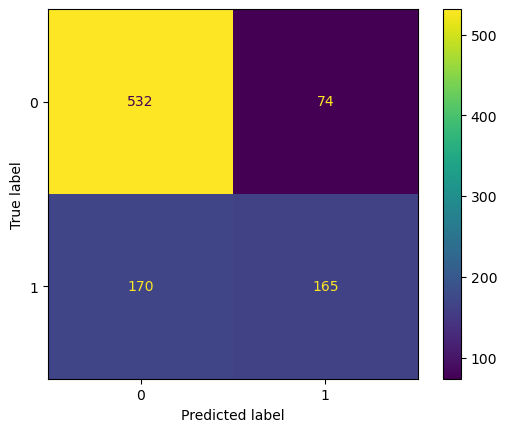

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_r_2)
disp.plot(values_format='.0f')
plt.show()

In [41]:
rnd_clf_3 = RandomForestClassifier(n_estimators=100, random_state=42)
Full_Exp_rf, conf_r_3, top_10_ex = Random_Forest(X_tm, X_tesm, y_tm, y_tesm, rnd_clf_3)
Full_Exp_rf

,Go-Ids,go_function,F1-Score,Accuracy
5,GO:0008150,biological_process,0.642857,0.585106
2,GO:0005488,binding,0.378987,0.647872
4,GO:0005575,cellular_component,0.387755,0.744681
7,GO:0009987,cellular process,0.200000,0.744681
0,GO:0003674,molecular_function,0.851924,0.758511
3,GO:0005515,protein binding,0.231293,0.759574
1,GO:0003824,catalytic activity,0.658268,0.769149
9,GO:0110165,cellular anatomical entity,0.416422,0.788298
6,GO:0008152,metabolic process,0.444444,0.803191
8,GO:0071704,organic substance metabolic process,0.365019,0.822340


In [42]:
top_10_ex

,mean
Q,0.025450
E,0.025549
S_E,0.025598
P,0.025732
F,0.025878
P_B,0.026183
Hydrophobicity,0.026208
V,0.026332
H,0.026509
P_C,0.026557


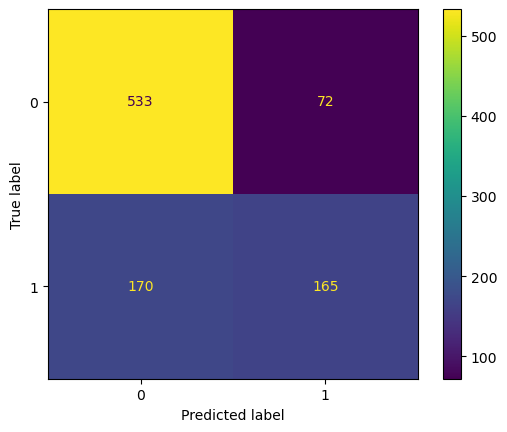

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_r_3)
disp.plot(values_format='.0f')
plt.show()

In [44]:
rnd_clf_4 = RandomForestClassifier(n_estimators=100, random_state=42)
Removed_rf, conf_r_4, top_10_rem = Random_Forest(X_tmr, X_tesmr, y_tmr, y_tesmr, rnd_clf_4)
Removed_rf

,Go-Ids,go_function,F1-Score,Accuracy
5,GO:0008150,biological_process,0.638565,0.571277
2,GO:0005488,binding,0.366472,0.654255
4,GO:0005575,cellular_component,0.383202,0.750000
0,GO:0003674,molecular_function,0.850065,0.755319
3,GO:0005515,protein binding,0.217687,0.755319
7,GO:0009987,cellular process,0.206897,0.755319
1,GO:0003824,catalytic activity,0.658268,0.769149
9,GO:0110165,cellular anatomical entity,0.402367,0.785106
6,GO:0008152,metabolic process,0.382445,0.790426
8,GO:0071704,organic substance metabolic process,0.305882,0.811702


In [45]:
top_10_rem

,mean
K,0.028675
I,0.028787
G,0.028789
A,0.028985
S,0.029226
E,0.029246
L,0.029564
Q,0.029564
P_B,0.030037
V,0.030094


In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_r_4)
disp.plot(values_format='.0f')
plt.show()

## Neural Network

In [ ]:
def nural_network(X_1_N, X_2_N, y_1_N, y_2_N,nn):
    combined_data = pd.concat([X_1_N, X_2_N], axis=0)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(combined_data)
    scaled_data = pd.DataFrame(scaled_data,columns=X_1_N.columns)
    X_1_N = scaled_data.iloc[:2191,:]
    X_2_N = scaled_data.iloc[2191:,:]
    Records = pd.DataFrame(columns=['Go-Ids', 'F1-Score','Accuracy','Confusion_Matrix'])
    for column in y_1_N.columns:
        temp = []
        a = y_1_N[column]
        b = y_2_N[column]
        nn.fit(X_1_N, a)
        y_pred_N = nn.predict(X_2_N)
        confusion = confusion_matrix(b, y_pred_N)
        temp.append(column)
        temp.append(f1_score(b, y_pred_N))
        temp.append(accuracy_score(b,y_pred_N))
        temp.append(confusion)
        Records.loc[len(Records)] = temp
    mean_confusion_matrix_nn = sum(Records['Confusion_Matrix']) / len(Records)
    Records = Records.drop(columns=['Confusion_Matrix'])
    Records = Records.merge(Names, left_on='Go-Ids', right_on='go_go_id')
    Records = Records.drop(columns=['go_go_id'])
    Records = Records.iloc[:,[0,3,1,2]]
    Records = Records.sort_values(by='Accuracy', ascending=True)
    return Records, mean_confusion_matrix_nn

In [ ]:
nn_1 = MLPClassifier(solver='adam',activation='logistic', alpha=0.001, 
                     hidden_layer_sizes=(100,50,25), max_iter=50,
                     random_state=42)
Records_m, conf_nn_1 = nural_network(X_train, X_test, y_train, y_test,nn_1)
Records_m 

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_nn_1)
disp.plot(values_format='.0f')
plt.show()

In [ ]:
nn_2 = MLPClassifier(solver='adam', alpha=0.001, 
                     hidden_layer_sizes=(100,50,25), max_iter=50,
                     random_state=42)
Records_f, conf_nn_2 = nural_network(X_t, X_tes, y_t, y_tes,nn_2)
Records_f

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_nn_2)
disp.plot(values_format='.0f')
plt.show()

In [ ]:
nn_3 = MLPClassifier(solver='adam', alpha=0.001, 
                     hidden_layer_sizes=(100,50,25), max_iter=50,
                     random_state=42)
Records_my, conf_nn_3 = nural_network(X_tm, X_tesm, y_tm, y_tesm,nn_3)
Records_my

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_nn_3)
disp.plot(values_format='.0f')
plt.show()

In [ ]:
nn_4 = MLPClassifier(solver='adam', alpha=0.001, 
                     hidden_layer_sizes=(100,50,25), max_iter=50,
                     random_state=42)
Records_removed, conf_nn_4 = nural_network(X_tmr, X_tesmr, y_tmr, y_tesmr,nn_4)
Records_removed

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_nn_4)
disp.plot(values_format='.0f')
plt.show()

## Hard Voting

In [ ]:
def hard_voting(X_1_H,X_2_H,y_1_H,y_2_H,voting_classifier_hard):
    combined_data = pd.concat([X_1_H, X_2_H], axis=0)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(combined_data)
    scaled_data = pd.DataFrame(scaled_data,columns=X_1_H.columns)
    X_1_H = scaled_data.iloc[:2191,:]
    X_2_H = scaled_data.iloc[2191:,:]
    Records = pd.DataFrame(columns=['Go-Ids', 'F1-Score','Accuracy'])
    for column in y_1_H.columns:
        temp = []
        a = y_1_H[column]
        b = y_2_H[column]
        voting_classifier_hard.fit(X_1_H, a)
        y_pred_H = voting_classifier_hard.predict(X_2_H)
        temp.append(column)
        temp.append(f1_score(b, y_pred_H))
        temp.append(accuracy_score(b,y_pred_H))
        Records.loc[len(Records)] = temp
    Records = Records.merge(Names, left_on='Go-Ids', right_on='go_go_id')
    Records = Records.drop(columns=['go_go_id'])
    Records = Records.iloc[:,[0,3,1,2]]
    Records = Records.sort_values(by='Accuracy', ascending=True)
    return Records

In [ ]:
voting_classifier_hard_1 = VotingClassifier(estimators=[
    ('svc', SVC(kernel="poly", degree=3, coef0=1, C=5)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('nn', MLPClassifier(solver='adam', activation='logistic', alpha=0.001, hidden_layer_sizes=(100, 50, 25), max_iter=50, random_state=42))
], voting='hard')
base_h = hard_voting(X_train, X_test, y_train, y_test,voting_classifier_hard_1)
base_h

In [ ]:
voting_classifier_hard_2 = VotingClassifier(estimators=[
    ('svc', SVC(kernel="poly", degree=3, coef0=1, C=5)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('nn', MLPClassifier(solver='adam', activation='logistic', alpha=0.001, hidden_layer_sizes=(100, 50, 25), max_iter=50, random_state=42))
], voting='hard')
full_h = hard_voting(X_t, X_tes, y_t, y_tes,voting_classifier_hard_2)
full_h

In [ ]:
voting_classifier_hard_3 = VotingClassifier(estimators=[
    ('svc', SVC(kernel="poly", degree=3, coef0=1, C=5)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('nn', MLPClassifier(solver='adam', activation='logistic', alpha=0.001, hidden_layer_sizes=(100, 50, 25), max_iter=50, random_state=42))
], voting='hard')
full_exp_h = hard_voting(X_tm, X_tesm, y_tm, y_tesm,voting_classifier_hard_3)
full_exp_h

In [ ]:
voting_classifier_hard_4 = VotingClassifier(estimators=[
    ('svc', SVC(kernel="poly", degree=3, coef0=1, C=5)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('nn', MLPClassifier(solver='adam', activation='logistic', alpha=0.001, hidden_layer_sizes=(100, 50, 25), max_iter=50, random_state=42))
], voting='hard')
removed_h = hard_voting(X_tmr, X_tesmr, y_tmr, y_tesmr,voting_classifier_hard_4)
removed_h

## Soft Voting

In [ ]:
def soft_voting(X_1_S,X_2_S,y_1_S,y_2_S,voting_classifier_soft):
    combined_data = pd.concat([X_1_S, X_2_S], axis=0)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(combined_data)
    scaled_data = pd.DataFrame(scaled_data,columns=X_1_S.columns)
    X_1_S = scaled_data.iloc[:2191,:]
    X_2_S = scaled_data.iloc[2191:,:]
    Records = pd.DataFrame(columns=['Go-Ids', 'F1-Score','Accuracy'])
    for column in y_1_S.columns:
        temp = []
        a = y_1_S[column]
        b = y_2_S[column]
        voting_classifier_soft.fit(X_1_S, a)
        y_pred_S = voting_classifier_soft.predict(X_2_S)
        temp.append(column)
        temp.append(f1_score(b, y_pred_S))
        temp.append(accuracy_score(b,y_pred_S))
        Records.loc[len(Records)] = temp
    Records = Records.merge(Names, left_on='Go-Ids', right_on='go_go_id')
    Records = Records.drop(columns=['go_go_id'])
    Records = Records.iloc[:,[0,3,1,2]]
    Records = Records.sort_values(by='Accuracy', ascending=True)
    return Records

In [ ]:
voting_classifier_soft_1 = VotingClassifier(estimators=[
    ('svc', SVC(kernel="poly", degree=3, coef0=1, C=5,probability=True)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('nn', MLPClassifier(solver='adam', activation='logistic', alpha=0.001, hidden_layer_sizes=(100, 50, 25), max_iter=50, random_state=42))
], voting='soft')
base_s = soft_voting(X_train, X_test, y_train, y_test,voting_classifier_soft_1)
base_s

In [ ]:
voting_classifier_soft_2 = VotingClassifier(estimators=[
    ('svc', SVC(kernel="poly", degree=3, coef0=1, C=5,probability=True)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('nn', MLPClassifier(solver='adam', activation='logistic', alpha=0.001, hidden_layer_sizes=(100, 50, 25), max_iter=50, random_state=42))
], voting='soft')
full_s = soft_voting(X_t, X_tes, y_t, y_tes,voting_classifier_soft_2)
full_s

In [ ]:
voting_classifier_soft_3 = VotingClassifier(estimators=[
    ('svc', SVC(kernel="poly", degree=3, coef0=1, C=5,probability=True)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('nn', MLPClassifier(solver='adam', activation='logistic', alpha=0.001, hidden_layer_sizes=(100, 50, 25), max_iter=50, random_state=42))
], voting='soft')
full_exp_s = soft_voting(X_tm, X_tesm, y_tm, y_tesm,voting_classifier_soft_3)
full_exp_s

In [ ]:
voting_classifier_soft_4 = VotingClassifier(estimators=[
    ('svc', SVC(kernel="poly", degree=3, coef0=1, C=5,probability=True)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('nn', MLPClassifier(solver='adam', activation='logistic', alpha=0.001, hidden_layer_sizes=(100, 50, 25), max_iter=50, random_state=42))
], voting='soft')
removed_s = soft_voting(X_tmr, X_tesmr, y_tmr, y_tesmr,voting_classifier_soft_4)
removed_s

## Creating CSV for Data

In [ ]:
#def multiple_dfs(list_of_dfs):
#    with open('all_dfs.csv','a') as f:
#       for df in list_of_dfs:
#            df.to_csv(f)
#            f.write("\n")

#dfs = [Records,Full_Records,My_Full_Records,My_Full_Records_R,
#       DT_Records, My_Full_DT, My_data_DT, My_data_DT_R,
#       Records_RF, My_Full_RF, My_data_RF, My_data_RF_R ]
#multiple_dfs(dfs)